In [ ]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

In [ ]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="deepseek-r1-distill-llama-70b")
llm.invoke("hi").content

In [ ]:
## Import all the necessary libraries

from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode

In [ ]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

In [ ]:
state={"messages":["hi hello how are you?"]}
call_model(state)

In [ ]:
workflow = StateGraph(MessagesState)

In [ ]:
workflow.add_node("vivek_bot", call_model)

In [ ]:
workflow.add_edge(START, "vivek_bot")

In [ ]:
workflow.add_edge("vivek_bot", END)

In [ ]:
app = workflow.compile()

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [ ]:
app.invoke({"messages":"hi hello how are you?"})

In [118]:
@tool
def search(query: str) :
    """This is a tool to search weather information"""
    if 'adoni' in query.lower():
        return "The weather in Adoni is 45 degrees celsius"
    else:
        return "The temperature is 30 degrees celsius"

In [119]:
search.invoke("What is the weather in Adon?")

'The temperature is 30 degrees celsius'

In [120]:
tools = [search]

In [121]:
tool_node = ToolNode(tools)

In [122]:
llm_with_tools = llm.bind_tools(tools)

In [123]:
llm_with_tools.invoke("What is the weather in Adoni?").content

''

In [124]:
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [125]:
state={"messages":["What is the weather in Adoni?"]}
call_model(state)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '569t304nq', 'function': {'arguments': '{"query":"Adoni weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 113, 'prompt_tokens': 132, 'total_tokens': 245, 'completion_time': 0.552130006, 'prompt_time': 0.008931038, 'queue_time': 0.063876765, 'total_time': 0.561061044}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c6ab1353-52d8-494d-ba53-89a6a5c64680-0', tool_calls=[{'name': 'search', 'args': {'query': 'Adoni weather'}, 'id': '569t304nq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 132, 'output_tokens': 113, 'total_tokens': 245})]}

In [126]:
def router(state: MessagesState):
    messages = state["messages"]
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return END
    

In [127]:
workflow_2 = StateGraph(MessagesState)

In [128]:
workflow_2.add_node("llm_with_tools", call_model)


In [129]:
workflow_2.add_node("mytools", tool_node) 

In [130]:
workflow_2.add_edge(START, "llm_with_tools")

In [131]:
workflow_2.add_conditional_edges("llm_with_tools",
                                router,
                                {"tools":"mytools",
                                 END:END})

In [132]:
app2=workflow_2.compile()


In [ ]:

from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [ ]:
response=app2.invoke({"messages":["what is a weather in adoni?"]})


In [ ]:
response["messages"][-1].content


In [ ]:
response_1 = app2.invoke({"messages":["what is a weather in oni?"]})
response_1["messages"][-1].content

In [133]:
workflow_2.add_edge("mytools","llm_with_tools")


Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [134]:
app3=workflow_2.compile()

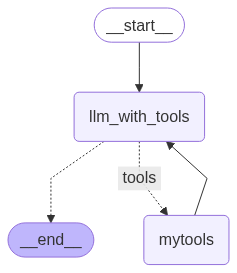

In [135]:
from IPython.display import Image, display
display(Image(app3.get_graph().draw_mermaid_png()))

In [137]:
for output in app3.stream({"messages":["what is a weather in Adoni?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")


here is output from llm_with_tools
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fh0y1npq6', 'function': {'arguments': '{"query":"Adoni weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 126, 'prompt_tokens': 132, 'total_tokens': 258, 'completion_time': 0.579051928, 'prompt_time': 0.008438096, 'queue_time': 0.071582704, 'total_time': 0.587490024}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e7fbb445-f173-416a-8889-bb0e6f93248b-0', tool_calls=[{'name': 'search', 'args': {'query': 'Adoni weather'}, 'id': 'fh0y1npq6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 132, 'output_tokens': 126, 'total_tokens': 258})]}


here is output from mytools
_______
{'messages': [ToolMessage(content='The weather in Adoni is 45 degrees celsius', name='search', id='f8e10a23-66a8-412f-a1ae-67f932b99ba2

In [138]:
from langgraph.checkpoint.memory import MemorySaver

In [139]:
memory=MemorySaver()


In [141]:
workflow3=StateGraph(MessagesState)

workflow3.add_node("llmwithtool",call_model)

workflow3.add_node("mytools",tool_node)

workflow3.add_edge(START,"llmwithtool")

workflow3.add_conditional_edges("llmwithtool",
                                router,
                                {"tools":"mytools",
                                 END:END})

workflow3.add_edge("mytools","llmwithtool")

In [142]:
app4=workflow3.compile(checkpointer=memory)


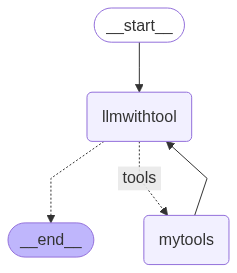

In [143]:
from IPython.display import Image, display
display(Image(app4.get_graph().draw_mermaid_png()))


In [144]:
config={"configurable": {"thread_id": "1"}}

In [147]:
events=app4.stream(
    {"messages":["what is a weather in Adoni delhi?"]},config=config,stream_mode="values"
    )

In [148]:
for event in events:
    event["messages"][-1].pretty_print()


================================ Human Message =================================

what is a weather in Adoni delhi?
================================== Ai Message ==================================
Tool Calls:
  search (f4mxj25n6)
 Call ID: f4mxj25n6
  Args:
    query: weather in Adoni Delhi
================================= Tool Message =================================
Name: search

The weather in Adoni is 45 degrees celsius
================================== Ai Message ==================================

It seems there might be some confusion. Adoni is not located in Delhi; it is a city in Karnataka, India. The weather in Adoni is currently **45 degrees Celsius**. If you meant to ask about Delhi, please let me know, and I'll be happy to provide that information!
